In [1]:
import numpy as np
import pandas as pd
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


In [2]:
import os


In [3]:
print("Current Working Directory:")
print(os.getcwd())


Current Working Directory:
C:\Users\Sharanya P A


In [4]:
fake = pd.read_csv(r"C:\Users\Sharanya P A\Fake.csv")
true = pd.read_csv(r"C:\Users\Sharanya P A\True.csv")

print("Fake shape:", fake.shape)
print("True shape:", true.shape)


Fake shape: (23481, 4)
True shape: (21417, 4)


In [5]:
fake["label"] = 0
true["label"] = 1


In [6]:
df = pd.concat([fake, true], axis=0)
df = df.reset_index(drop=True)

print("Total rows:", df.shape)
df.head()


Total rows: (44898, 5)


,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0


In [7]:
df = df[["title", "text", "label"]]
df.isnull().sum()


title    0
text     0
label    0
dtype: int64

In [8]:
df["content"] = df["title"] + " " + df["text"]
df = df[["content", "label"]]
df.head()


,content,label
0,Donald Trump Sends Out Embarrassing New Year’...,0
1,Drunk Bragging Trump Staffer Started Russian ...,0
2,Sheriff David Clarke Becomes An Internet Joke...,0
3,Trump Is So Obsessed He Even Has Obama’s Name...,0
4,Pope Francis Just Called Out Donald Trump Dur...,0


In [9]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'<.*?>+', '', text)
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub(r'\n', '', text)
    text = re.sub(r'\w*\d\w*', '', text)
    return text


In [10]:
df["content"] = df["content"].apply(clean_text)


In [11]:
df = df.sample(frac=1, random_state=42).reset_index(drop=True)


In [12]:
x = df["content"]
y = df["label"]

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.25, random_state=42
)


In [13]:
vectorizer = TfidfVectorizer(
    stop_words="english",
    max_df=0.8,
    min_df=2,
    ngram_range=(1,2)
)

xv_train = vectorizer.fit_transform(x_train)
xv_test = vectorizer.transform(x_test)

print("Vocabulary size:", len(vectorizer.vocabulary_))


Vocabulary size: 1158326


In [14]:
LR = LogisticRegression(
    max_iter=5000,
    class_weight="balanced",
    random_state=42
)

LR.fit(xv_train, y_train)


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,42
,solver,'lbfgs'
,max_iter,5000
,multi_class,'deprecated'


In [15]:
LR = LogisticRegression(max_iter=5000, class_weight="balanced")
LR.fit(xv_train, y_train)

PAC = PassiveAggressiveClassifier(max_iter=1000)
PAC.fit(xv_train, y_train)

SVC = LinearSVC()
SVC.fit(xv_train, y_train)


,penalty,'l2'
,loss,'squared_hinge'
,dual,'auto'
,tol,0.0001
,C,1.0
,multi_class,'ovr'
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,verbose,0
,random_state,None


In [16]:
models = {
    "Logistic Regression": LR,
    "Passive Aggressive": PAC,
    "Linear SVC": SVC
}

for name, model in models.items():
    y_pred = model.predict(xv_test)
    print("\n", name)
    print("Accuracy:", accuracy_score(y_test, y_pred))



 Logistic Regression
Accuracy: 0.984053452115813

 Passive Aggressive
Accuracy: 0.9946547884187082

 Linear SVC
Accuracy: 0.99456570155902


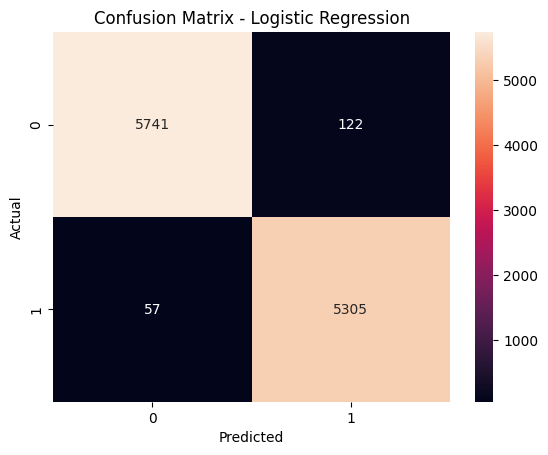

              precision    recall  f1-score   support

           0       0.99      0.98      0.98      5863
           1       0.98      0.99      0.98      5362

    accuracy                           0.98     11225
   macro avg       0.98      0.98      0.98     11225
weighted avg       0.98      0.98      0.98     11225



In [17]:
y_pred = LR.predict(xv_test)

cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

print(classification_report(y_test, y_pred))


In [19]:
from sklearn.ensemble import VotingClassifier

voting_model = VotingClassifier(
    estimators=[
        ('lr', LR),
        ('pac', PAC),
        ('svc', SVC)
    ],
    voting='hard'
)

voting_model.fit(xv_train, y_train)

y_pred_vote = voting_model.predict(xv_test)

print("Voting Accuracy:", accuracy_score(y_test, y_pred_vote))


Voting Accuracy: 0.9942093541202672


In [20]:
def output_label(n):
    return "Fake News ❌" if n == 0 else "True News ✅"

def manual_testing(news):
    cleaned = clean_text(news)
    vectorized = vectorizer.transform([cleaned])

    if vectorized.sum() == 0:
        print("⚠ News contains unknown words. Try longer article.")
        return

    pred_lr = LR.predict(vectorized)[0]
    pred_pac = PAC.predict(vectorized)[0]
    pred_svc = SVC.predict(vectorized)[0]

    final_prediction = round((pred_lr + pred_pac + pred_svc) / 3)

    print("Logistic:", output_label(pred_lr))
    print("Passive Aggressive:", output_label(pred_pac))
    print("Linear SVC:", output_label(pred_svc))
    print("\nFinal Prediction:", output_label(final_prediction))


In [23]:
news = input("Enter News Text: ")
manual_testing(news)


Enter News Text: Former Bangladesh Prime Minister Sheikh Hasina late Friday reacted sharply to the recently held general elections in the South Asian nation, dismissing the February 12 polls as a “pre-planned election of deception and farce” and calling it a “disgraceful chapter” in the country’s history. Her remarks come as her party, the Awami League, remained entirely absent from the electoral contest, while Hasina continues to live in exile in New Delhi following her ouster in August 2024 over security concerns.
Logistic: True News ✅
Passive Aggressive: True News ✅
Linear SVC: True News ✅

Final Prediction: True News ✅
